In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import seaborn as sns
import random
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.grid_search import GridSearchCV
import time

In [3]:
# Load data
data_train = pd.read_csv("/Users/apple/Desktop/duke/Fall2016/CS571/HW5/pml_train.csv")
data_test = pd.read_csv("/Users/apple/Desktop/duke/Fall2016/CS571/HW5/pml_test_features.csv")
# Remove the first column
data_train = data_train.ix[:,1:len(data_train.columns)]
data_train.shape


(131822, 131)

In [4]:
# Find the columns with categorical data in training dataset and change them to 0/1
cols = data_train.columns
num_cols = data_train._get_numeric_data().columns
cat_col = list(set(cols) - set(num_cols))
for column in cat_col:
    data_train[column] = pd.factorize(data_train[column].values, sort=True)[0]

In [5]:
# Find the columns with categorical data in test dataset and change them to 0/1
cols_test = data_test.columns
num_cols_test = data_test._get_numeric_data().columns
cat_col_test = list(set(cols) - set(num_cols))
for column in cat_col_test:
    data_test[column] = pd.factorize(data_test[column].values, sort=True)[0]

#### Exploratory Data Analysis

- Categorical data

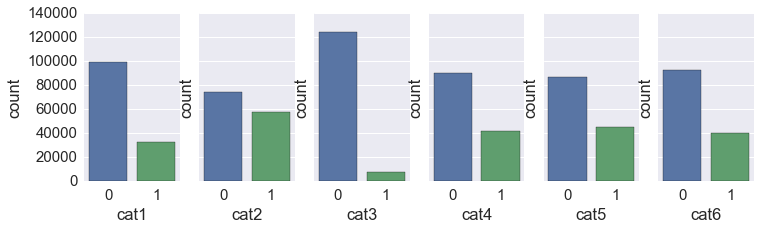

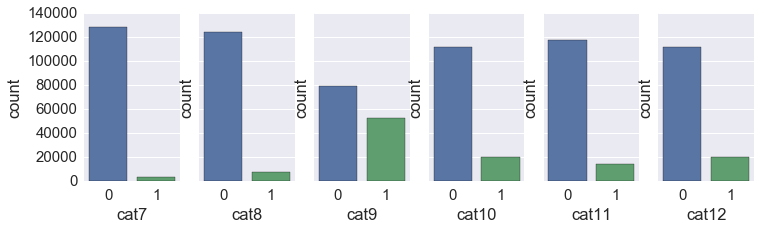

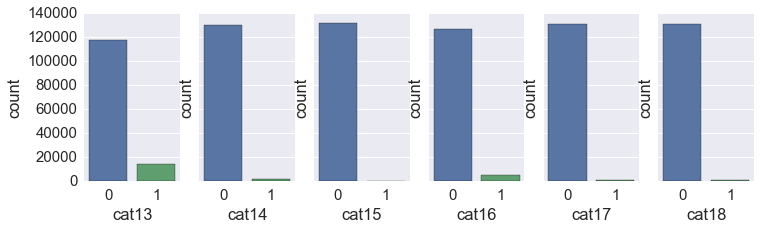

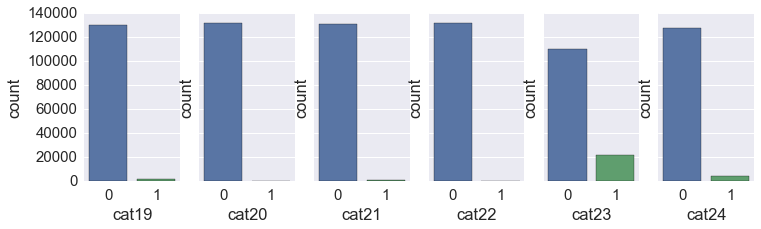

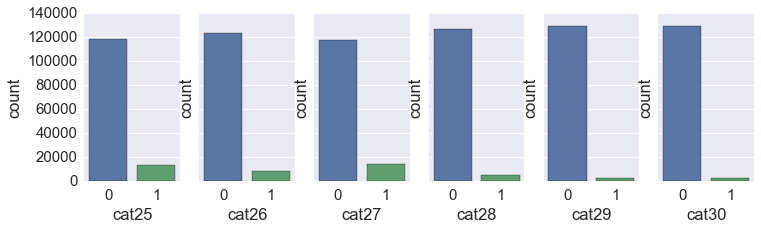

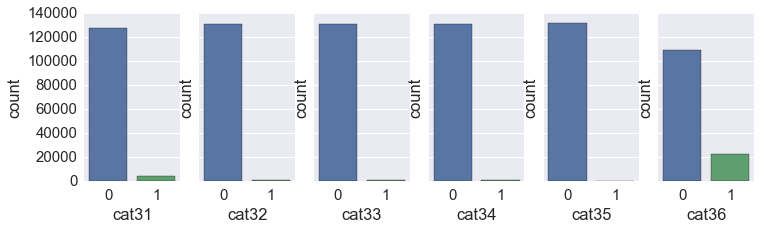

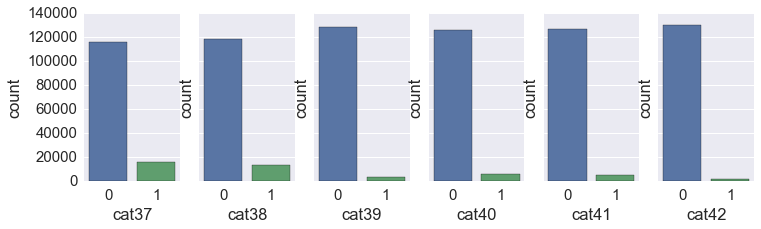

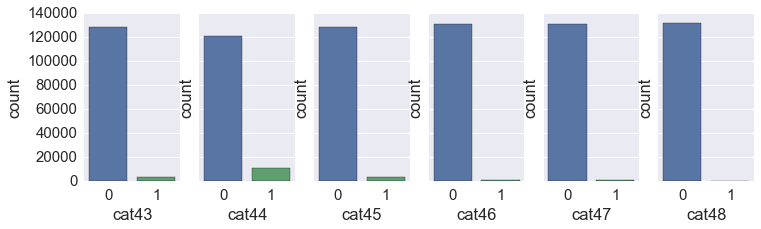

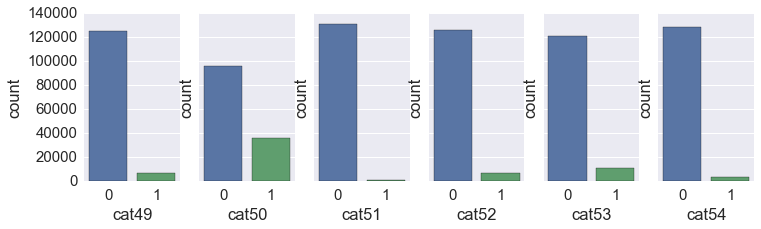

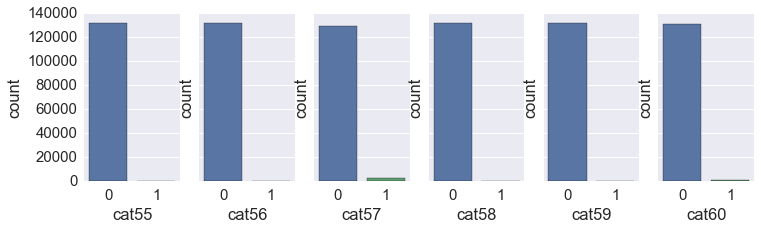

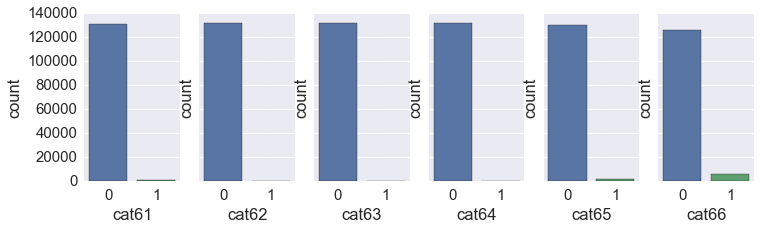

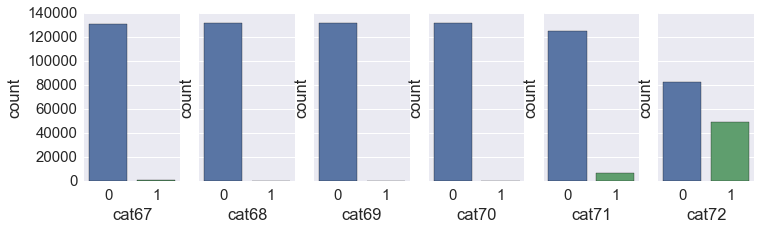

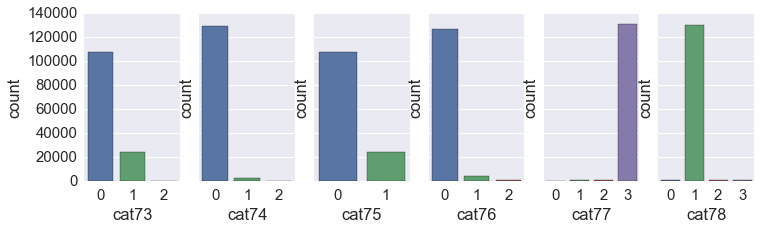

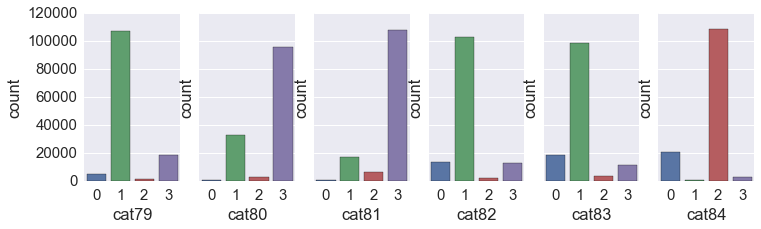

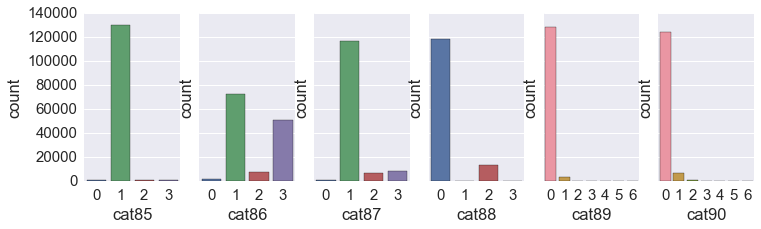

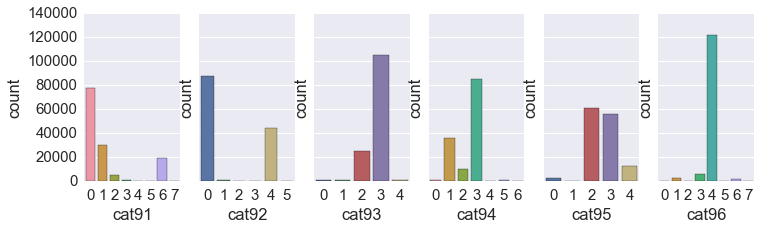

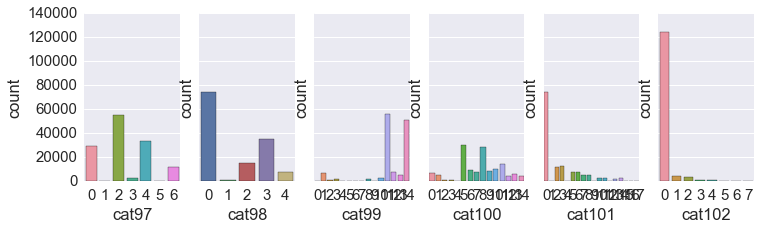

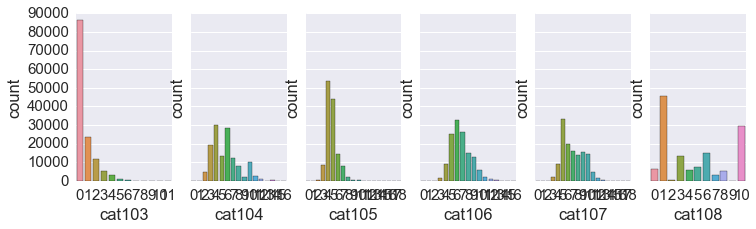

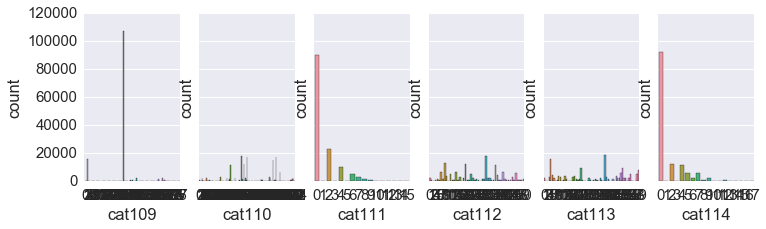

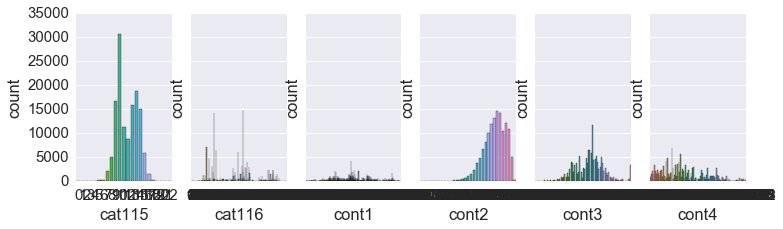

In [156]:
# Plot the barplot on every categorical features
n_cols = 6
n_rows = 20
for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,sharey=True,figsize=(12, 3))
    for j in range(n_cols):
        sns.countplot(data_train.ix[:,i*n_cols+j],ax=ax[j])

- Numerical data

In [6]:
# Get the dataframe with numerical data
data_train_num = data_train[num_cols]
data_train_num = data_train_num.ix[:,:-1]

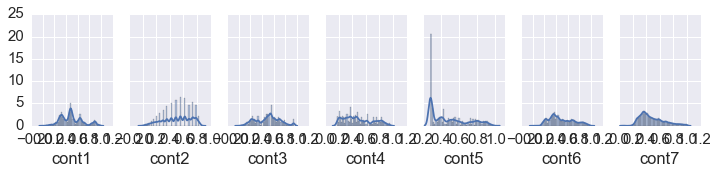

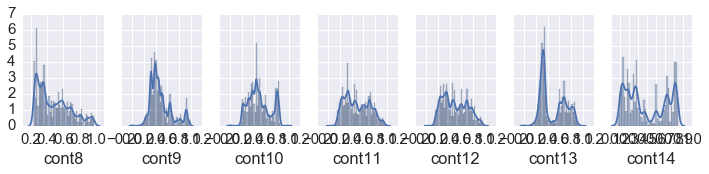

In [7]:
# Get the distribution plot for each numerical variable
n_cols = 7
n_rows = 2
for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,sharey=True,figsize=(12, 2))
    for j in range(n_cols):
        sns.distplot(data_train_num.ix[:,i*n_cols+j],ax=ax[j])

cat11 and cat12 = 0.99
cat1 and cat9 = 0.93
cat6 and cat10 = 0.88
cat6 and cat13 = 0.81
cat1 and cat10 = 0.81
cat6 and cat9 = 0.80
cat9 and cat10 = 0.79
cat6 and cat12 = 0.78
cat6 and cat11 = 0.77
cat1 and cat6 = 0.76
cat7 and cat11 = 0.75
cat7 and cat12 = 0.74
cat10 and cat12 = 0.71
cat10 and cat13 = 0.71
cat10 and cat11 = 0.70


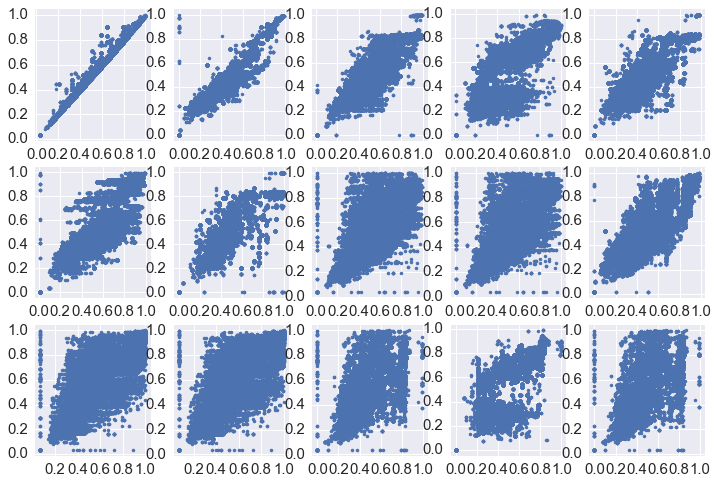

In [85]:
# Calculates  coefficient for all combinations
data_corr = data_train_num.corr()

corr_pair= []
threshold = 0.7

#List pairs that are highly correlated, say greater than threshold
for i in range(len(data_corr.columns)): 
    for j in range(i+1,len(data_corr.columns)): 
        if (np.abs(data_corr.ix[i,j]) >= threshold and np.abs(data_corr.ix[i,j]) < 1):
            corr_pair.append([data_corr.ix[i,j],i,j]) 

#Sort pair from highest to lowest           
corr_pair_s = sorted(corr_pair,reverse=True)

#Print correlations and column names
for c,i,j in corr_pair_s:
    print ("%s and %s = %.2f" % (cols[i],cols[j],c))

# Plot scatter plot on each selected pair of features
n_cols = 5
n_rows = 3
fg,ax = plt.subplots(3,5,figsize=(12, 8))
for i in range(n_rows): 
    for j in range(n_cols):
        ans = corr_pair_s[i*n_cols+j]
        ax[i,j].plot(data_train_num.ix[:,ans[1]],data_train_num.ix[:,ans[2]],".",)
for axs in ax.ravel():
    axs.margins(0.05)
pass

- Explained variable

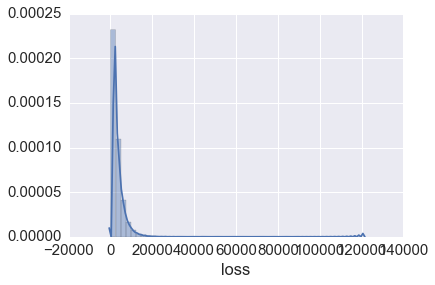

In [9]:
# Split traing dataset into X and y
data_train_x = data_train.ix[:,:-1]
data_train_y = data_train.ix[:,-1]
data_test_x = data_test.ix[:,1:]

# Visualize the distribution plot of y 
sns.distplot(data_train_y)

<function matplotlib.pyplot.show>

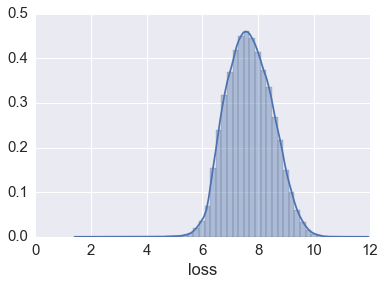

In [10]:
# Since the distribution plot of y is highly skewed, it's better to take log on it and get a normal distribution 
data_train_y_log = np.log(data_train_y)
sns.distplot(data_train_y_log)
plt.show

#### Data Preparation

- Lasso CV


runtime for lasso_cv is  13.548243999481201 s


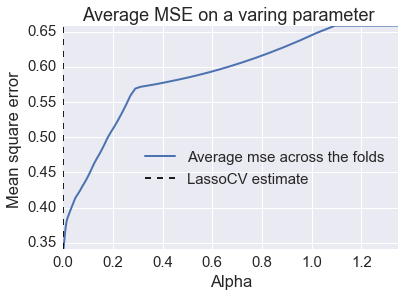

In [86]:
# lasso cv
from sklearn.linear_model import LassoCV
import time

#record the runtime
start_time = time.time()
lcv = LassoCV(cv=10,normalize = True).fit(data_train_x,data_train_y_log)
time_lcv = time.time() - start_time

# Calculate the average mse aross the fold for every choice of alpha
mse = np.mean(lcv.mse_path_,axis= 1)


plt.plot(lcv.alphas_,mse,label='Average mse across the folds', linewidth=2)
plt.axvline(lcv.alpha_, linestyle='--', color='k',label='LassoCV estimate')
plt.legend(loc='bottom right', bbox_to_anchor=(1, 0.5))
plt.xlabel('Alpha')
plt.ylabel('Mean square error ')
plt.title("Average MSE on a varing parameter ")
plt.axis('tight')
print("runtime for lasso_cv is ",time_lcv,"s")

In [108]:
# Save the result
y_lcv = np.exp(lcv.predict(data_test_x))
result_lcv = pd.DataFrame()
result_lcv['id'] = data_test.id
result_lcv['loss'] = y_lcv

result_lcv.to_csv('result_lasso.csv', index=False)


- XGB

In [87]:
# First,fit a simple xgboost without any hyperparameter selection
start_time = time.time()
xgb = XGBRegressor()
xgb.fit(data_train_x,data_train_y_log)

time_xgb = time.time() - start_time
print("Runtime for simple xgb is", time_xgb, "s")


Runtime for xgb is 83.3036539554596 s


In [136]:
# Hyperparameter selection
start_time = time.time()
xgb = XGBRegressor()
param_grid = { 
     'n_estimators': [10, 50, 100],
     'min_child_weight': [3,5,7],
     'max_depth': [5,10,15,20]
}

# Grid search cv for xgb
CV_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv = 5)

# Fit the best model among the parameters combination in the parameter pool 
CV_xgb.fit(data_train_x, data_train_y_log)

time_xgbcv = time.time() - start_time
print("Runtime for xgb with hyperparameters selection is", time_xgbcv, "s")



GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 10, 15, 20], 'n_estimators': [10, 50, 100], 'min_child_weight': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [137]:
# Get the best parameters
CV_xgb.best_params_

{'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 100}

In [141]:
# predicted values
y_hat = np.exp(CV_xgb.predict(data_test_x))

In [72]:
# save the result
result_xgb = pd.DataFrame()
result_xgb['id'] = data_test.id
result_xgb['loss'] = y_hat

result.to_csv('result_xgb.csv', index=False)

#### Test and Compare

In [49]:
from sklearn.cross_validation import train_test_split


# Split the original trainig dataset into new training dataset and test dataset
train, test= train_test_split(data_train, test_size=0.20, random_state=42)
train_x = train.ix[:,:-1]
test_x = test.ix[:,:-1]
train_y = train.ix[:,-1]
test_y = test.ix[:,-1]
train_y_log = np.log(train_y)

In [91]:
# Evaluate the effectiveness of lasso and xgboost via mean absolute error
# lasso
lcv_test = LassoCV(cv=10).fit(train_x,train_y_log)
y_lcv_hat = np.exp(lcv_test.predict(test_x))


In [92]:
# xgboost
xgb_test = XGBRegressor(max_depth=6,min_child_weight = 3,n_estimators= 200)
xgb_test.fit(train_x,train_y_log)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=3, missing=None, n_estimators=200, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [99]:
# predicted value
y_xgb_hat = np.exp(xgb_test.predict(test_x))

In [100]:
from sklearn.metrics import mean_absolute_error

# compute the mean-absolute-error for two models
abe_lasso = mean_absolute_error(y_lcv_hat, test_y)
abe_xgb = mean_absolute_error(y_xgb_hat, test_y)
print ("The mean absolute error for Lasso is", abe_lasso)
print ("The mean absolute error for xgb is", abe_xgb)

The mean absolute error for Lasso is 1328.70154676
The mean absolute error for xgb is 1160.89519181


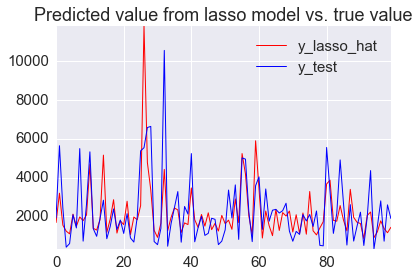

In [133]:
# visually represent the accuracy of my models and the predictions 
plt.plot(range(100),y_lcv_hat[0:100],'r-',linewidth = 1, label = "y_lasso_hat")
plt.plot(range(100),test_y[0:100],'b-',linewidth = 1,label = "y_test")
plt.title('Predicted value from lasso model vs. true value')
plt.axis('tight')
plt.legend()



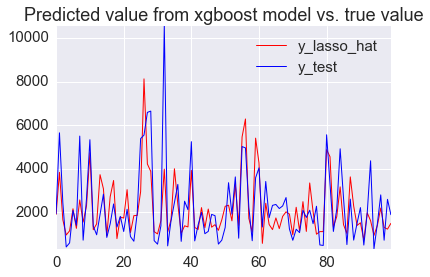

In [134]:
plt.plot(range(100),y_xgb_hat[0:100],'r-',linewidth = 1,label = "y_lasso_hat")
plt.plot(range(100),test_y[0:100],'b-',linewidth = 1,label = "y_test")
plt.title('Predicted value from xgboost model vs. true value')
plt.axis('tight')
plt.legend()